In [1]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# System and OS-related imports
import os
import subprocess

# Image processing and manipulation
import cv2
import numpy as np
from PIL import Image

# PyTorch-related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler

# Vision and deep learning models
from torchvision import transforms, models
import lpips

# Plotting and visualization
import matplotlib.pyplot as plt

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.tanh = nn.Tanh()  
    def forward(self, x):
        return self.tanh(self.conv(x))

class UNetFrameInterpolation(nn.Module):
    def __init__(self, n_channels=6, n_out_channels=3):
        super(UNetFrameInterpolation, self).__init__()
       
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)  
       
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
       
        self.outc = OutConv(64, n_out_channels)
    def forward(self, x):
        x1 = self.inc(x)  
        x2 = self.down1(x1) 
        x3 = self.down2(x2) 
       
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
       
        return self.outc(x)

# Dataset
class Vimeo90KDataset(Dataset):
    def __init__(self, root_dir, list_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        with open(list_file, 'r') as f:
            self.sequences = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq_path = os.path.join(self.root_dir, seq)

        im1 = Image.open(os.path.join(seq_path, 'im1.png')).convert('RGB')
        im2 = Image.open(os.path.join(seq_path, 'im2.png')).convert('RGB')  
        im3 = Image.open(os.path.join(seq_path, 'im3.png')).convert('RGB')

        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            im3 = self.transform(im3)

        input_tensor = torch.cat([im1, im3], dim=0) 
        return input_tensor, im2  

transform = transforms.Compose([
    transforms.ToTensor(),                         
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       
                         std=[0.5, 0.5, 0.5])
])

Using device: cuda


In [4]:
root_dir = '/kaggle/input/vimeo-90k-video-dataset/vimeo_triplet/sequences'
train_list = '/kaggle/input/vimeo-90k-video-dataset/vimeo_triplet/tri_trainlist.txt'
test_list = '/kaggle/input/vimeo-90k-video-dataset/vimeo_triplet/tri_testlist.txt'  

# Datasets
train_dataset_full = Vimeo90KDataset(root_dir=root_dir, list_file=train_list, transform=transform)
val_dataset = Vimeo90KDataset(root_dir=root_dir, list_file=test_list, transform=transform)  

# Subsets for quick testing 
train_subset_indices = list(range(min(20000, len(train_dataset_full))))
train_dataset = Subset(train_dataset_full, train_subset_indices)

val_subset_indices = list(range(min(2000, len(val_dataset))))  
val_dataset = Subset(val_dataset, val_subset_indices)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)  

# TRAINING SETUP
model = UNetFrameInterpolation().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler('cuda')

print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples...")

Training on 20000 samples, validating on 2000 samples...


In [5]:
class LPIPSLoss(nn.Module):
    def __init__(self, net='alex'):  
        super().__init__()
        self.loss_fn = lpips.LPIPS(net=net)
        self.loss_fn.eval()  
        for param in self.loss_fn.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        return self.loss_fn(pred, target).mean() 

def psnr(mse):
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(2.0 / torch.sqrt(mse)) 

In [6]:
lpips_loss = LPIPSLoss(net='alex').to(device)

num_epochs = 50
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_psnr = 0.0
    
    for input_frames, target in train_dataloader:
        input_frames = input_frames.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):  
            output = model(input_frames)
            
            loss_main = criterion(output, target)
            loss_lpips = lpips_loss(output, target)

            loss = 1 * loss_main + 0.2 * loss_lpips
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        batch_loss = loss.item()
        train_loss += batch_loss
        
        mse = F.mse_loss(output, target, reduction='mean')
        batch_psnr = psnr(mse)
        train_psnr += batch_psnr.item()

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_psnr = train_psnr / len(train_dataloader)

    # Validation 
    model.eval()
    val_loss = 0.0
    val_psnr = 0.0
    
    with torch.no_grad():
        for input_frames, target in val_dataloader:
            input_frames = input_frames.to(device)
            target = target.to(device)
            
            with autocast(device_type='cuda'):  
                output = model(input_frames)
                
                loss_main = criterion(output, target)
                loss_lpips = lpips_loss(output, target)
    
                loss = 1 * loss_main + 0.2 * loss_lpips
            
            batch_loss = loss.item()
            val_loss += batch_loss
            
            mse = F.mse_loss(output, target, reduction='mean')  
            batch_psnr = psnr(mse)
            val_psnr += batch_psnr.item()

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_psnr = val_psnr / len(val_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.6f} | Train PSNR: {avg_train_psnr:.2f} dB | "
          f"Val Loss: {avg_val_loss:.6f} | Val PSNR: {avg_val_psnr:.2f} dB")

    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'frame_interpolation_best.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}")
        break

model.load_state_dict(torch.load('frame_interpolation_best.pth'))
print("Training complete! Best model saved as 'frame_interpolation_best.pth'")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 196MB/s] 


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Epoch 1/50 - Train Loss: 0.123675 | Train PSNR: 22.20 dB | Val Loss: 0.083773 | Val PSNR: 23.89 dB
Epoch 2/50 - Train Loss: 0.098287 | Train PSNR: 23.43 dB | Val Loss: 0.078173 | Val PSNR: 24.68 dB
Epoch 3/50 - Train Loss: 0.087021 | Train PSNR: 24.42 dB | Val Loss: 0.070542 | Val PSNR: 25.45 dB
Epoch 4/50 - Train Loss: 0.080454 | Train PSNR: 25.08 dB | Val Loss: 0.072411 | Val PSNR: 25.61 dB
Epoch 5/50 - Train Loss: 0.075149 | Train PSNR: 25.57 dB | Val Loss: 0.064937 | Val PSNR: 26.22 dB
Epoch 6/50 - Train Loss: 0.071009 | Train PSNR: 25.95 dB | Val Loss: 0.061145 | Val PSNR: 26.52 dB
Epoch 7/50 - Train Loss: 0.069459 | Train PSNR: 26.14 dB | Val Loss: 0.060557 | Val PSNR: 26.67 dB
Epoch 8/50 - Train Loss: 0.067109 | Train PSNR: 26.36 dB | Val Loss: 0.058888 | Val PSNR: 26.82 dB
Epoch 9/50 - Train Loss: 0.065009 | Train PSNR: 26.57 dB | Val Loss: 0.059557 | Val PSNR: 26.92 dB
Epoch 10/50 - Train L

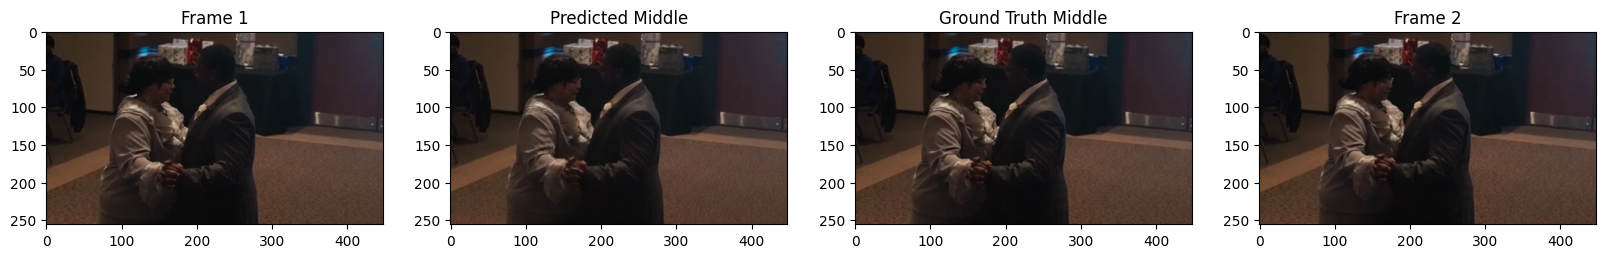

In [7]:
model.eval()
with torch.no_grad():
    sample_in, sample_gt = next(iter(val_dataloader))
    sample_in = sample_in.to(device)
    pred = model(sample_in[:1])
    def denorm(img):
        return ((img.cpu().clamp(-1,1) + 1) / 2).permute(1,2,0).numpy()
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1); plt.title("Frame 1"); plt.imshow(denorm(sample_in[0][:3]))
    plt.subplot(1,4,2); plt.title("Predicted Middle"); plt.imshow(denorm(pred[0]))
    plt.subplot(1,4,3); plt.title("Ground Truth Middle"); plt.imshow(denorm(sample_gt[0]))
    plt.subplot(1,4,4); plt.title("Frame 2"); plt.imshow(denorm(sample_in[0][-3:]))
    plt.show()

In [8]:
def get_video_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0 or fps > 1000:  
        print("Warning: Detected FPS is invalid. Falling back to 30 FPS.")
        fps = 30.0
    else:
        print(f"Detected original FPS: {fps:.2f}")
    cap.release()
    return fps

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(Image.fromarray(frame))
    cap.release()
    if len(frames) == 0:
        raise ValueError("No frames loaded. Check if the video path is correct and file is accessible.")
    return frames

# Video path
video_path = '/kaggle/input/bird-doing-stuff/bird.mp4'

# Load frames
original_frames = load_video_frames(video_path)
print(f"Original video: {len(original_frames)} frames")

# Detect original FPS
original_fps = get_video_fps(video_path)

# Generate interpolated frames
model.eval()
interpolated_frames = []
with torch.no_grad():
    for i in range(len(original_frames) - 1):
        f1 = transform(original_frames[i]).unsqueeze(0).to(device)
        f2 = transform(original_frames[i+1]).unsqueeze(0).to(device)
        input_pair = torch.cat([f1, f2], dim=1)  
        pred = model(input_pair) 
        # Convert to PIL Image
        img = (pred[0].clamp(-1, 1).cpu() + 1) / 2  
        img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        interpolated_frames.append(Image.fromarray(img))

# Build final smooth sequence
final_frames = []
for i in range(len(original_frames) - 1):
    final_frames.append(original_frames[i])        
    final_frames.append(interpolated_frames[i])      
final_frames.append(original_frames[-1])           

# Save video at normal speed 
def save_video_normal_speed(frames, output_path, original_fps):
    if len(frames) == 0:
        raise ValueError("No frames to save.")
    width, height = frames[0].size[0], frames[0].size[1]  
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_fps = original_fps * 2 
    out = cv2.VideoWriter(output_path, fourcc, output_fps, (width, height))
    
    for frame in frames:
        frame_bgr = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    
    out.release()
    print(f"Video saved → {output_path} at {output_fps:.2f} FPS")

# Save the result
silent_video_path = 'interpolated_video.mp4'
save_video_normal_speed(final_frames, silent_video_path, original_fps)

final_output_path = 'interpolated_video_with_audio.mp4'

subprocess.run([
    'ffmpeg',
    '-i', silent_video_path,     
    '-i', video_path,            
    '-c:v', 'copy',             
    '-c:a', 'aac',              
    '-map', '0:v:0',             
    '-map', '1:a:0',             
    '-shortest',               
    '-y',                       
    final_output_path
], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

print("Your buttery smooth video is ready!")

Original video: 134 frames
Detected original FPS: 30.00
Video saved → interpolated_video.mp4 at 60.00 FPS
Your buttery smooth video is ready!
